In [1]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyaashah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saumyaashah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyaashah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading Data

In [2]:
df_raw = pd.read_json('news_articles_with_text_3_sources.json')

In [3]:
df_raw.head()

,source,author,title,url,publishedAt,article_text
0,"{'id': 'abc-news', 'name': 'ABC News'}","MARIAM FAM, DEEPTI HAJELA and LUIS ANDRES HENA...","Two decades after 9/11, Muslim Americans still...",https://abcnews.go.com/Lifestyle/wireStory/dec...,2021-09-07T07:27:55Z,Muslim Americans who grew up under the shadow ...
1,"{'id': 'abc-news', 'name': 'ABC News'}",TERESA M. WALKER AP Pro Football Writer,"Titans' outbreak nears end, other NFL teams de...",https://abcnews.go.com/Sports/wireStory/titans...,2021-09-07T03:31:36Z,The Tennessee Titans COVID-19 outbreak is near...
2,"{'id': 'abc-news', 'name': 'ABC News'}",Dr. Priscilla Hanudel,COVID-19 infection after vaccination and what ...,https://abcnews.go.com/Health/covid-19-infecti...,2021-09-07T14:28:39Z,Vaccines work to dramatically reduce the risk ...
3,"{'id': 'abc-news', 'name': 'ABC News'}",Alisa Wiersema,Texas governor signs GOP-backed 'election inte...,https://abcnews.go.com/Politics/texas-governor...,2021-09-07T17:34:12Z,Three months and two special sessions after Te...
4,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Spanish hospital baby switch discovered two de...,https://abcnews.go.com/Lifestyle/wireStory/spa...,2021-09-07T17:07:13Z,Health authorities in Spain are blaming human ...


### Pre-processing and Tokenization

In [4]:
def clean_text(text):
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", " ", text)  # Remove [+XYZ chars] in content
    #text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)  # Remove numbers in content
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )  # Remove punctuation
    return text

def tokenize(text, tokenizer, stopwords):
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    tokens = [lemmatizer.lemmatize(t, pos ='v') for t in tokens]
    return tokens

In [5]:
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
#text_columns = ["title", "author", "article_text"]

df = df_raw.copy()
df["article_text"] = df["article_text"].fillna("")

df['text'] = df['article_text'].astype(str)

#df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["text"] = df["text"].map(lambda x: clean_text(x))
df["tokens"] = df["text"].map(lambda x: tokenize(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (1500, 6)
Pre-processed dataframe: (570, 2)


In [6]:
df.head()

,text,tokens
201,in the aftermath of president joe biden s late...,"[aftermath, president, joe, biden, latest, ann..."
1031,ahead of tuesday s groundbreaking on the obama...,"[ahead, tuesday, groundbreaking, obama, presid..."
1114,an air force veteran who pleaded guilty to a m...,"[air, force, veteran, plead, guilty, misdemean..."
633,alicia and herman lopez remember how much thei...,"[alicia, herman, lopez, remember, much, son, h..."
321,allies of former president donald trump are ca...,"[ally, former, president, donald, trump, call,..."


In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
df["tokenized_text"] = df["tokens"].map(lambda x: " ".join([str(item) for item in x]))

In [9]:
df

,text,tokens,tokenized_text
201,in the aftermath of president joe biden s late...,"[aftermath, president, joe, biden, latest, ann...",aftermath president joe biden latest announcem...
1031,ahead of tuesday s groundbreaking on the obama...,"[ahead, tuesday, groundbreaking, obama, presid...",ahead tuesday groundbreaking obama presidentia...
1114,an air force veteran who pleaded guilty to a m...,"[air, force, veteran, plead, guilty, misdemean...",air force veteran plead guilty misdemeanor joi...
633,alicia and herman lopez remember how much thei...,"[alicia, herman, lopez, remember, much, son, h...",alicia herman lopez remember much son hunter l...
321,allies of former president donald trump are ca...,"[ally, former, president, donald, trump, call,...",ally former president donald trump call charge...
...,...,...,...
721,new york former president george w bush wi...,"[york, former, president, george, bush, headli...",york former president george bush headline fun...
107,a young girl who was tortured and shot multi...,"[young, girl, torture, shoot, multiple, time, ...",young girl torture shoot multiple time former ...
342,if youre like me and cant wait until oct to c...,"[youre, like, cant, wait, oct, celebrate, th, ...",youre like cant wait oct celebrate th annivers...
313,the youth feels a sense of institutional betr...,"[youth, feel, sense, institutional, betrayal, ...",youth feel sense institutional betrayal bring ...


### Get Named Entities

In [10]:
df["ner"] = df["tokenized_text"].map(lambda x: len(nlp(x).ents))

In [11]:
df["ner_vals"] = df["tokenized_text"].map(lambda x: nlp(x).ents)

In [12]:
df["ner_vals"] = df["ner_vals"].map(lambda x: [str(item) for t in x for item in t])
#df["ner_vals"] = df["ner_vals"].map(lambda x: [str(item) for  item in t])

In [50]:
df

,text,tokens,tokenized_text,ner,ner_vals
201,in the aftermath of president joe biden s late...,"[aftermath, president, joe, biden, latest, ann...",aftermath president joe biden latest announcem...,30,"[joe, biden, week, american, americans, lawren..."
1031,ahead of tuesday s groundbreaking on the obama...,"[ahead, tuesday, groundbreaking, obama, presid...",ahead tuesday groundbreaking obama presidentia...,27,"[tuesday, chicago, jackson, park, chicago, fou..."
1114,an air force veteran who pleaded guilty to a m...,"[air, force, veteran, plead, guilty, misdemean...",air force veteran plead guilty misdemeanor joi...,13,"[air, force, wednesday, days, mark, first, mis..."
633,alicia and herman lopez remember how much thei...,"[alicia, herman, lopez, remember, much, son, h...",alicia herman lopez remember much son hunter l...,21,"[alicia, herman, disneyland, park, november, l..."
321,allies of former president donald trump are ca...,"[ally, former, president, donald, trump, call,...",ally former president donald trump call charge...,46,"[donald, trump, washington, first, donald, tru..."
...,...,...,...,...,...
721,new york former president george w bush wi...,"[york, former, president, george, bush, headli...",york former president george bush headline fun...,53,"[george, bush, next, month, donald, trump, liz..."
107,a young girl who was tortured and shot multi...,"[young, girl, torture, shoot, multiple, time, ...",young girl torture shoot multiple time former ...,27,"[sharpshooter, four, thursday, year, old, flor..."
342,if youre like me and cant wait until oct to c...,"[youre, like, cant, wait, oct, celebrate, th, ...",youre like cant wait oct celebrate th annivers...,26,"[oct, one, months, week, four, one, four, day,..."
313,the youth feels a sense of institutional betr...,"[youth, feel, sense, institutional, betrayal, ...",youth feel sense institutional betrayal bring ...,15,"[first, tuesday, nearly, half, first, lisa, va..."


### Filter out articles with <2 NEs

In [13]:
df = df[df['ner'] > 2]

In [14]:
numbered_ners = df['ner_vals'].values.tolist()

In [15]:
tokenized_docs = df['tokens'].values.tolist()

In [16]:
docs = df['text'].values.tolist()

### Get NE Embeddings

In [17]:
model = Word2Vec(sentences=numbered_ners, vector_size=100, workers=1, seed=SEED)

In [18]:
model.wv.most_similar("biden")

[('democratic', 0.9993303418159485),
 ('congress', 0.9993020296096802),
 ('tuesday', 0.9993001818656921),
 ('joe', 0.999247133731842),
 ('american', 0.9992201328277588),
 ('republican', 0.9992197155952454),
 ('thursday', 0.999214231967926),
 ('gop', 0.9992128610610962),
 ('wednesday', 0.9991728663444519),
 ('week', 0.9991698861122131)]

In [19]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(numbered_ners, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(563, 100)

### Clustering 

In [21]:
def mbkmeans_clusters(X, k, mb, print_silhouette_values):
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [22]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=30,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 30
Silhouette coefficient: 0.23
Inertia:0.6975634896281628
Silhouette values:
    Cluster 12: Size:2 | Avg:0.85 | Min:0.84 | Max: 0.86
    Cluster 7: Size:3 | Avg:0.83 | Min:0.76 | Max: 0.87
    Cluster 3: Size:5 | Avg:0.48 | Min:0.22 | Max: 0.63
    Cluster 23: Size:5 | Avg:0.43 | Min:0.08 | Max: 0.58
    Cluster 21: Size:4 | Avg:0.43 | Min:0.25 | Max: 0.51
    Cluster 13: Size:15 | Avg:0.42 | Min:-0.01 | Max: 0.61
    Cluster 8: Size:7 | Avg:0.41 | Min:0.14 | Max: 0.53
    Cluster 20: Size:12 | Avg:0.35 | Min:0.02 | Max: 0.53
    Cluster 1: Size:19 | Avg:0.33 | Min:0.14 | Max: 0.46
    Cluster 16: Size:49 | Avg:0.33 | Min:0.06 | Max: 0.53
    Cluster 24: Size:21 | Avg:0.32 | Min:0.06 | Max: 0.50
    Cluster 27: Size:13 | Avg:0.30 | Min:0.14 | Max: 0.45
    Cluster 18: Size:5 | Avg:0.29 | Min:0.16 | Max: 0.48
    Cluster 2: Size:16 | Avg:0.27 | Min:-0.02 | Max: 0.48
    Cluster 0: Size:20 | Avg:0.26 | Min:0.01 | Max: 0.51
    Cluster 5: Size:32 | Avg:0.24 | Min:0.03 |

### Get top articles per cluster

In [51]:
cluster_21=[]
test_cluster = 21
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    cluster_21.append(numbered_ners[d])
print(numbered_ners[d])

['hours', 'joe', 'biden', 'thursday', 'earlier', 'day', 'hundreds', 'thousands', 'hours', 'thursday', 'night', 'senate', 'chuck', 'schumer', 'republican', 'billion', 'afghan', 'senate', 'later', 'thursday', 'afternoon', 'hours', 'thursday', 'white', 'house', 'fiscal', 'year', 'december', 'republicans', 'senate', 'mcconnell', 'democrats', 'republicans', 'mcconnell', 'today', 'democrats', 'republicans', 'gop', 'week', 'thursday', 'american', 'treasury', 'janet', 'yellen', 'americans', 'oct', 'senate', 'appropriations', 'committee', 'patrick', 'vt', 'republicans', 'billions', 'mcconnell', 'democrats', 'billion', 'israel', 'democrats', 'democrats', 'abc', 'justin', 'gomez']
['democrats', 'white', 'house', 'democratic', 'senate', 'thursday', 'white', 'house', 'democrats', 'joe', 'biden', 'white', 'house', 'next', 'monday', 'senate', 'chuck', 'schumer', 'treasury', 'janet', 'yellen', 'weekly', 'democrats', 'oct', 'republicans', 'white', 'house', 'senate', 'democrats', 'senate', 'next', 'week

In [30]:
for d in most_representative_docs[:10]:
    print(docs[d])

the stopgap funding bill made it to his desk just hours before the deadline  president joe biden on thursday evening signed a deal the house and senate passed earlier in the day to avert a government shutdown that would have affected hundreds of thousands of federal workers and slammed an economy still struggling to recover from the pandemic  all with just hours left to stave off a crisis   it meets critical and urgent needs of the nation   the president said in a statement thursday night  but he also noted   theres so much more to do   under the deal  announced by senate majority leader chuck schumer  senators dispensed with a handful of republican amendments and then approved     a temporary funding bill that not only averts a shutdown until dec    but also includes    billion in disaster aid for states ravaged by extreme weather and    billion to further assist afghan refugees  the house passed the senate version of the stopgap measure later thursday afternoon     just hours before 

In [25]:
cluster_21_tsne = list(set([item for sublist in cluster_21 for item in sublist]))

In [52]:
cluster_21_tsne

['minute',
 'trump',
 'davis',
 'tweet',
 'watkins',
 'exxon',
 'st',
 'week',
 'advance',
 'monday',
 'josh',
 'zero',
 'boe',
 'million',
 'budget',
 'decade',
 'psaki',
 'rutledge',
 'blunt',
 'republicans',
 'joe',
 'janine',
 'luetkemeyer',
 'harris',
 'months',
 'kansas',
 'sanders',
 'lawler',
 'sarah',
 'khanna',
 'political',
 'oklahoma',
 'bill',
 'energy',
 'taylor',
 'phil',
 'roughly',
 'mcauliffe',
 'earlier',
 'gov',
 'four',
 'mike',
 'huckabee',
 'five',
 'columbus',
 'calif',
 'michigan',
 'chuck',
 'terry',
 'marc',
 'akin',
 'trillion',
 'years',
 'sunday',
 'december',
 'murphy',
 'boozman',
 'york',
 'jen',
 'martinez',
 'republican',
 'commonwealth',
 'remark',
 'echo',
 'tomorrow',
 'israel',
 'polytechnic',
 'billion',
 'bernie',
 'moran',
 'television',
 'today',
 'kristen',
 'diego',
 'face',
 'area',
 'hundreds',
 'one',
 'thursday',
 'month',
 'virginia',
 'gomez',
 'california',
 'tour',
 'afternoon',
 'levy',
 'strong',
 'key',
 'several',
 'warren',
 'ca

In [66]:
cluster_23=[]
test_cluster = 23
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    cluster_23.append(numbered_ners[d])

In [67]:
for d in most_representative_docs[:10]:
    print(docs[d])

to celebrate the recent premieres of two new series on disney junior    spidey and his amazing friends  and  mickey mouse funhouse   guests at disney springs are able to team up with mickey and spidey and strike a pose in front of these colorful photo walls now through september   if your weekend plans include other magical destinations  ill tell you one more way to make funhouse photo magic for a limited time  both new series feature beloved iconic characters starring in brand new stories for kids and families to enjoy  the whimsical animated series  mickey mouse funhouse  introduces preschoolers first pal  mickey mouse  and his friends   minnie  goofy  donald  daisy and pluto   to funny  an enchanted talking playhouse  who takes the sensational six on adventures of all types to unique worlds that inspire the imagination   spidey and his amazing friends  follows peter parker  gwen stacy and miles morales and their adventures as the young heroes team up with hulk  ms  marvel and black 

In [70]:
cluster_23_tsne = list(set([item for sublist in cluster_23 for item in sublist]))

### Visualize NEs per cluster using t-SNE

In [45]:
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import numpy as np

In [46]:
def tsne_plot(model,words):
    labels = []
    tokens = []

    #for word in list(model.wv.index_to_key):
    for word in words:
        if word in list(model.wv.index_to_key):
            tokens.append(model.wv[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(50):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/saumyaashah/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/saumyaashah/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


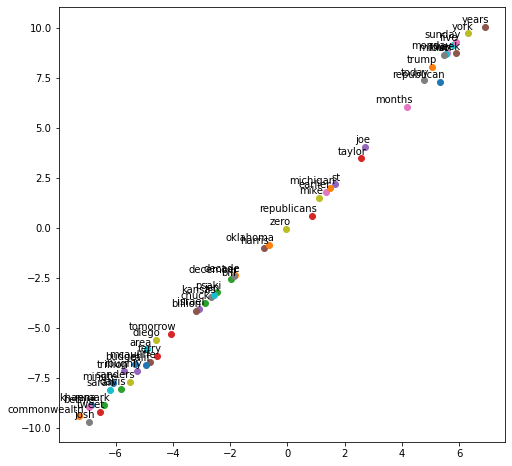

In [47]:
tsne_plot(model,cluster_21_tsne)

/Users/saumyaashah/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/saumyaashah/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


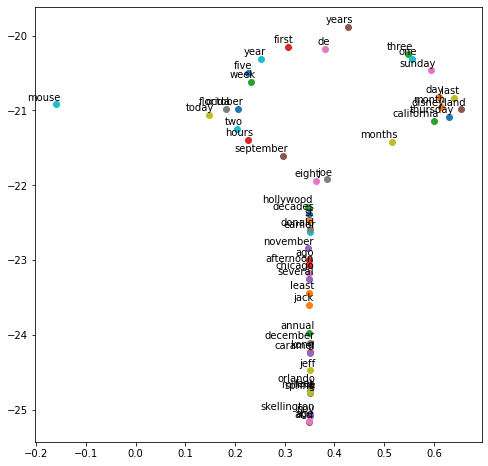

In [71]:
tsne_plot(model,cluster_23_tsne)

In [65]:
f = open('cluster_9.txt', 'w')
for d in most_representative_docs[:10]:
    f.write(docs[d])
    f.write('\n')
    f.write('\n')
f.close()

In [53]:
cluster_21_tsne = list(set([item for sublist in cluster_21 for item in sublist]))

In [58]:
print(sorted(cluster_21_tsne))

['abc', 'advance', 'afghan', 'afghanistan', 'afternoon', 'akin', 'alaska', 'amanda', 'america', 'american', 'americans', 'annual', 'appropriations', 'area', 'arizona', 'arkansas', 'august', 'bay', 'beebe', 'bernie', 'biden', 'bidens', 'bill', 'billion', 'billions', 'blaine', 'blunt', 'boe', 'boozman', 'bp', 'brunner', 'budget', 'calif', 'california', 'californians', 'call', 'capitol', 'carolyn', 'catalini', 'century', 'china', 'christian', 'chuck', 'city', 'clinton', 'columbus', 'committee', 'commonwealth', 'compare', 'congress', 'connecticut', 'conservative', 'couple', 'cox', 'daily', 'david', 'davis', 'day', 'days', 'decade', 'decades', 'december', 'democrat', 'democratic', 'democrats', 'department', 'diego', 'district', 'dodge', 'dollar', 'dollars', 'donald', 'earlier', 'eastern', 'echo', 'eight', 'elizabeth', 'energy', 'exxon', 'exxonmobil', 'face', 'faulconer', 'first', 'fiscal', 'five', 'florida', 'forty', 'four', 'fourth', 'friday', 'glenn', 'gomez', 'gop', 'gov', 'gray', 'gretc

In [55]:
cluster_9_tsne = list(set([item for sublist in cluster_9 for item in sublist]))

In [72]:
print(sorted(cluster_23_tsne))

['abu', 'afternoon', 'age', 'ago', 'annual', 'bb', 'california', 'caramel', 'cauldron', 'chicago', 'cookies', 'cruella', 'daisy', 'dante', 'day', 'de', 'dec', 'decades', 'december', 'disneyland', 'donald', 'duck', 'earlier', 'eight', 'eighteen', 'feet', 'first', 'five', 'florida', 'four', 'funhouse', 'gardner', 'genie', 'global', 'goofy', 'goofys', 'halloween', 'hei', 'holiday', 'hollywood', 'hong', 'hours', 'houston', 'il', 'jack', 'jeff', 'jenna', 'joe', 'karamell', 'kong', 'kuche', 'last', 'least', 'leave', 'mad', 'mcdonalds', 'mickey', 'miguel', 'minnie', 'monster', 'month', 'months', 'mouse', 'night', 'nights', 'nov', 'november', 'oct', 'october', 'one', 'orlando', 'season', 'select', 'sept', 'september', 'several', 'shape', 'six', 'skellington', 'spidey', 'spring', 'st', 'sunday', 'three', 'thursday', 'timothy', 'today', 'two', 'vahle', 'vil', 'week', 'weekend', 'weeks', 'year', 'years', 'zuris']


In [75]:
most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[21]], topn=20)

In [76]:
most_representative

[('tuesday', 0.9996969699859619),
 ('republican', 0.9996862411499023),
 ('congress', 0.9996764063835144),
 ('committee', 0.9996463060379028),
 ('thursday', 0.9996263980865479),
 ('washington', 0.999625027179718),
 ('democratic', 0.999610960483551),
 ('gop', 0.9996098875999451),
 ('monday', 0.9996064305305481),
 ('wednesday', 0.9995877742767334),
 ('scott', 0.9995808601379395),
 ('american', 0.9995768070220947),
 ('joe', 0.9995742440223694),
 ('biden', 0.9995537400245667),
 ('week', 0.9995455741882324),
 ('abc', 0.9995253086090088),
 ('virginia', 0.9994936585426331),
 ('national', 0.9994819164276123),
 ('earlier', 0.9994667172431946),
 ('zero', 0.9994475841522217)]

In [77]:
most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[9]], topn=20)

In [78]:
most_representative

[('abc', 0.9998254179954529),
 ('one', 0.9998136758804321),
 ('five', 0.9998037219047546),
 ('july', 0.9997876286506653),
 ('three', 0.9997854232788086),
 ('sunday', 0.9997815489768982),
 ('first', 0.9997755885124207),
 ('two', 0.9997754693031311),
 ('week', 0.9997726082801819),
 ('national', 0.9997645616531372),
 ('month', 0.9997615218162537),
 ('half', 0.9997601509094238),
 ('de', 0.9997574687004089),
 ('john', 0.9997533559799194),
 ('sept', 0.999750554561615),
 ('hours', 0.9997477531433105),
 ('saturday', 0.9997468590736389),
 ('days', 0.9997467994689941),
 ('months', 0.9997464418411255),
 ('day', 0.9997437000274658)]

In [79]:
most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[23]], topn=20)

In [80]:
most_representative

[('today', 0.9990912079811096),
 ('jack', 0.9990651607513428),
 ('oct', 0.9989615082740784),
 ('first', 0.9989088177680969),
 ('sept', 0.998812735080719),
 ('several', 0.998741626739502),
 ('hours', 0.9987406730651855),
 ('two', 0.9987292289733887),
 ('de', 0.9987131357192993),
 ('hollywood', 0.9986940622329712),
 ('four', 0.9986838698387146),
 ('six', 0.998679518699646),
 ('years', 0.9986721873283386),
 ('one', 0.9986623525619507),
 ('september', 0.9986444711685181),
 ('later', 0.9986360669136047),
 ('ago', 0.9986298680305481),
 ('five', 0.9986258149147034),
 ('year', 0.9986227750778198),
 ('june', 0.9986218214035034)]